In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
from Area2_analysis.lr_funcs import mp_fit_lag_r2, mp_sub_lag_r2
matplotlib.rc('font', size=18)

# Load data

In [2]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"

dataset_5ms = NWBDataset(filename, split_heldout=False)

speed = np.sqrt(np.sum(dataset_5ms.data['hand_vel'][:].T**2,axis=0)).to_numpy().reshape((-1,1))
dataset_5ms.add_continuous_data(speed,'speed')
acceleration = np.diff(speed, axis = 0, prepend=[speed[0]])
dataset_5ms.add_continuous_data(acceleration,'acceleration') #technically change of speed, for timing plots

xy_vel = dataset_5ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_5ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])

vel_acc = np.append(xy_vel, xy_acc, axis = 1)
dataset_5ms.add_continuous_data(vel_acc,'vel_acc')
# xyz_force = np.array([dataset_5ms.data['force']['x'].to_numpy(), dataset_5ms.data['force']['y'].to_numpy(), dataset_5ms.data['force']['z'].to_numpy()]).T
# dataset_5ms.add_continuous_data(xyz_force,'manip_force',chan_names = ['x','y','z'])

dataset_5ms.resample(5)
bin_width = dataset_5ms.bin_width
print(bin_width)

dataset_5ms.smooth_spk(40, name='smth_40')
# dataset_5ms.smooth_spk(20, name='smth_20')

# gaussian_kernel_width = 20 #in ms
# sigma = int(gaussian_kernel_width/bin_width)
# data_smoothed = gaussian_filter1d_oneside(dataset_5ms.data.spikes.to_numpy().astype(np.float64),sigma,axis=0)
# dataset_5ms.add_continuous_data(data_smoothed,'spikes_smth_20_oneside')

5


In [3]:
dataset_20ms = NWBDataset(filename, split_heldout=False)
xy_vel = dataset_20ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_20ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
dataset_20ms.resample(20)
bin_width = dataset_20ms.bin_width
print(bin_width)

20


In [3]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = active_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

# all_data = np.array(dataset_5ms.data.spikes_smth_20_oneside)
# print(all_data.shape)
# if not np.isnan(all_data).any():
#     scaler = StandardScaler()
#     X = scaler.fit_transform(all_data)
#     pca = PCA(n_components=n_dims,random_state = 42)
#     PCA_data = pca.fit_transform(X)
# print(PCA_data.shape)
# dataset_5ms.add_continuous_data(PCA_data,'PCA_20_oneside')
# print('PCA total var explained:',sum(pca.explained_variance_ratio_))

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA_40')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))


245 trials
153 neurons
(558262, 153)
(558262, 20)
PCA total var explained: 0.3876050770392774


In [5]:
n_dims = 20
active_mask = (~dataset_20ms.trial_info.ctr_hold_bump) & (dataset_20ms.trial_info.split != 'none')
passive_mask = (dataset_20ms.trial_info.ctr_hold_bump) & (dataset_20ms.trial_info.split != 'none')


all_data = np.array(dataset_20ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_20ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

(139566, 153)
(139566, 20)
PCA total var explained: 0.23821813378384826


In [4]:
#make dictionary for trial condition (reaching directions) for Stratified CV
trial_mask = active_mask
active_trials_idx = np.array(dataset_5ms.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset_5ms.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
    active_cond_dir_idx.append(np.where((dataset_5ms.trial_info['cond_dir'] == direction) & (dataset_5ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_5ms.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset_5ms.trial_info['bump_dir'] == direction) & (dataset_5ms.trial_info['ctr_hold_bump'] == True) & \
           (dataset_5ms.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

245 active trials
218 passive trials
[6. 4. 5. 4. 0. 2. 0. 5. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2.
 2. 7. 0. 4. 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2.
 1. 5. 1. 1. 1. 1. 1. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 6. 7. 2. 0. 0. 5. 7. 5. 1. 4. 2. 0. 0. 5.
 4. 6. 3. 6. 3. 6. 3. 1. 7. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5. 1.
 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0. 2.
 5. 1. 3. 0. 7. 2. 3. 1. 2. 2. 0. 4. 2. 1. 3. 5. 5. 2. 1. 4. 1. 1. 6. 4.
 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0. 0. 0. 3. 7.
 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4. 3. 3. 6. 1.
 0. 2. 0. 0. 3.]
245
[6. 3. 3. 2. 4. 0. 6. 1. 0. 3. 2. 7. 6. 6. 6. 5. 4. 5. 3. 0. 4. 1. 6. 6.
 1. 5. 1. 0. 7. 1. 4. 4. 7. 6. 7. 3. 3. 0. 3. 5. 6. 6. 3. 2. 1. 1. 4. 7.
 5. 4. 4. 4. 7. 4. 3. 0. 7. 0. 0. 0. 7. 2. 5. 3. 5. 2. 7. 2. 5. 7.

In [7]:
df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=(-500,800), ignored_trials=~active_mask)
n_trials = df['trial_id'].nunique()
acc_array = df['hand_acc'].to_numpy().reshape(n_trials, -1, 2)
vel_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)

x_axis = np.arange(-500, 800, dataset_5ms.bin_width)

In [15]:
from sklearn.linear_model import LinearRegression
lag_axis = np.arange(-200, 200, 5)
n_runs = 25
ang_arr = nans([n_runs])
r2_arr = nans([n_runs, len(lag_axis)])
for b in range(n_runs):
    mu, sigma = 0, 1
    n_nrn = 20

    nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,2)) # Random We and Wa

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.tile(nrn_weight,(1,2)) # Random We = Wa

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.concatenate([nrn_weight, -nrn_weight], axis = 1) # Random We = -Wa

    nrn_axis = np.arange(-300, 700, 5)
    n_bins = len(nrn_axis)
    nrn_activity = nans([n_trials, n_bins, n_nrn])
    for n in range(n_nrn):
        for i in range(n_bins):
            for tr in range(n_trials):
                nrn_activity[tr, i, n] = nrn_weight[n,0]*vel_array[tr, i+np.argwhere(x_axis==-360)[0,0], 0] + nrn_weight[n, 1]*vel_array[tr, i+np.argwhere(x_axis==-220)[0,0], 0]

   
    coefs_arr = nans([len(lag_axis), n_nrn])
    r2 = nans([len(lag_axis)])
    for i in range(len(lag_axis)):
        start, end = 0+i, -80+i
        X = nrn_activity[:,start:end,:]
        X = X.reshape((X.shape[0]* X.shape[1]),X.shape[2])
        y = vel_array[:,np.argwhere(x_axis==-100)[0,0]:np.argwhere(x_axis==500)[0,0],0].reshape(-1,1)
        lr =  LinearRegression().fit(X, y)
        coefs_arr[i] = lr.coef_
        r2[i] = lr.score(X, y)
    ang_arr[b] = math.degrees(angle_between(coefs_arr[np.argwhere(lag_axis==-180)[0,0],:],coefs_arr[np.argwhere(lag_axis==0)[0,0],:])) 
    r2_arr[b,:] = r2

Text(0, 0.5, 'R2')

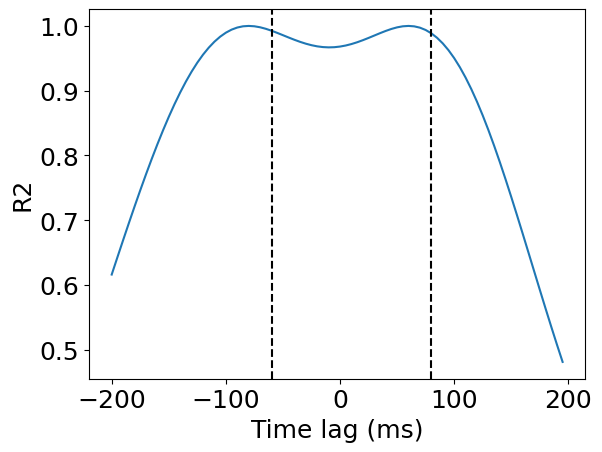

In [16]:
plt.plot(lag_axis, np.mean(r2_arr,axis=0))
plt.axvline(-60, color = 'k', linestyle='--')
plt.axvline(80, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R2')

Text(0, 0.5, 'Frequency')

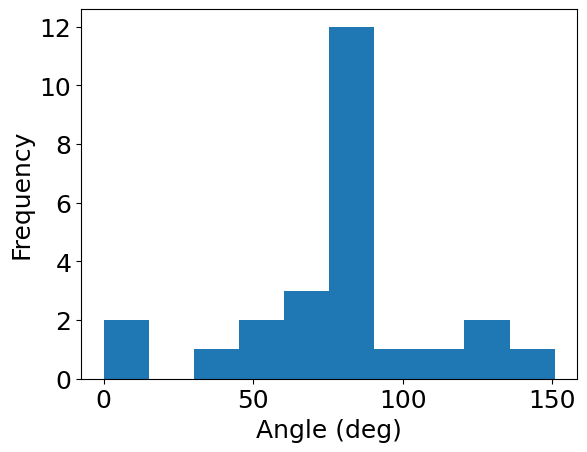

In [10]:
plt.hist(ang_arr)
plt.xlabel("Angle (deg)")
plt.ylabel('Frequency')

## Experimental Variables

In [ ]:
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'

In [ ]:
## Cross-correlation
df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range = (-100,500), ignored_trials = ~active_mask)
n_trials = df['trial_id'].nunique()

acc_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)
vel_array = df['hand_pos'].to_numpy().reshape(n_trials, -1, 2)
maxlags = 60

cc_arr = nans([n_trials, maxlags*2+1])
for i in range(n_trials):
    x = acc_array[i,:,0]
    y = vel_array[i,:,0]
    lags, c = xcorr(x, y, maxlags)
    cc_arr[i,:] = c
avg_c_x = np.mean(cc_arr, axis=0)

cc_arr = nans([n_trials, maxlags*2+1])
for i in range(n_trials):
    x = acc_array[i,:,1]
    y = vel_array[i,:,1]
    lags, c = xcorr(x, y, maxlags)
    cc_arr[i,:] = c
avg_c_y = np.mean(cc_arr, axis=0)

x_axis = lags*dataset_5ms.bin_width
plt.plot(x_axis, avg_c_x, color = 'green', label = 'x')
plt.plot(x_axis, avg_c_y, color = 'blue', label = 'y')
tmax = x_axis[int(np.mean((np.argmax(avg_c_x),np.argmax(avg_c_y))))]
plt.axvline(tmax, color = 'k',linestyle = '--')
print(tmax)
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Normalized cross-corr')

In [ ]:
## Autocorrelation
df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range = (-100,500), ignored_trials = ~active_mask)
n_trials = df['trial_id'].nunique()

acc_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)
print(acc_array.shape)
maxTimeLag = 500
binSize = dataset_5ms.bin_width
numBin = acc_array.shape[1]
x1 = acc_array[:,:,0]
x2 = acc_array[:,:,0]
ac_x = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

x1 = acc_array[:,:,1]
x2 = acc_array[:,:,1]
ac_y = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

time_axis = np.arange(0, maxTimeLag, binSize)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(time_axis,ac_x/ac_x[0],color = 'green', label = 'x')
ax.plot(time_axis,ac_y/ac_y[0],color = 'blue', label = 'y')
plt.legend()
plt.xlabel("Time lag (ms)")
plt.ylabel("Normalized autocorrelation")
plt.tight_layout()
# plt.savefig(figDir + monkey + '_autocorrelation_acc.pdf',dpi = 'figure')

In [ ]:
# Plot PCA projections over trial, for different reaching directions
pred_range = (-100, 500)
trial_mask = active_mask
cond_dict = active_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset_5ms.bin_width)
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
data = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial.PCA_40.to_numpy()
    i+=1
print(trials_pca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(pred_range[0], pred_range[1], dataset_5ms.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 8

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,i] 
        pca_mean = np.mean(data.PCA_40.to_numpy(),axis = 0)[i]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        ax[i].set_xlim([-100,500])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Active trials')
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_PCA_active.pdf',dpi = 'figure')

In [ ]:
# Plot PCA projections over trial, for different reaching directions
pred_range = (-100, 500)
trial_mask = passive_mask
cond_dict = passive_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset_5ms.bin_width)
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
data = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial.PCA_40.to_numpy()
    i+=1
print(trials_pca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(pred_range[0], pred_range[1], dataset_5ms.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 8

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,i] 
        pca_mean = np.mean(data.PCA_40.to_numpy(),axis = 0)[i]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        ax[i].set_xlim([-100,500])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Passive trials')
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_PCA_passive.pdf',dpi = 'figure')

### Timing plots

In [7]:
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')

figDir ='/Users/sherryan/area2_population_analysis/figures_plus/'

153 neurons


In [ ]:
plot_range = (-100, 200)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_5ms.bin_width)
passive_df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~passive_mask)
active_df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask)

# plt.figure(figsize=(10,6))
# for _, trial in active_df.groupby('trial_id'):
#     plt.plot(x_axis, trial.force['y'], color='k', linewidth=0.5)
# for _, trial in passive_df.groupby('trial_id'):
#     plt.plot(x_axis, trial.force['y'], color='red', linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Force to manipulandum (N)')
# plt.axvline(0, color = 'k',linestyle = '--')
# # plt.title('Force aligned to move_onset')
# plt.xlim([-40,100])
# plt.tight_layout()
# plt.savefig(figDir + monkey + '_force.pdf',dpi = 'figure')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial.speed, color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial.speed, color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand speed (cm/s)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Speed aligned to move_onset')
plt.xlim([-50,100])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_speed.pdf',dpi = 'figure')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial.acceleration, color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial.acceleration, color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Change of speed (cm/s^2)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Change of speed aligned to move_onset')
plt.xlim([-50,100])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_acceleration.pdf',dpi = 'figure')

In [ ]:
active_trials_spikes = []
for _, trial in active_df.groupby('trial_id'):
    active_trials_spikes.append(np.sum(trial.spikes,axis=1))
passive_trials_spikes = []
for _, trial in passive_df.groupby('trial_id'):
    passive_trials_spikes.append(np.sum(trial.spikes,axis=1))
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_5ms.bin_width*1000/len(active_trials_spikes)/n_neurons,"-o",color = 'k',label = 'Active')
plt.plot(x_axis,np.sum(passive_trials_spikes,axis = 0)/dataset_5ms.bin_width*1000/len(passive_trials_spikes)/n_neurons,"-o",color = 'red',label = 'Passive')

plt.legend()
# plt.title('Peristimulus aligned to move_onset')
plt.ylabel('Average Firing Rate (sp/s)')
plt.xlabel('Time after movement onset (ms)')
plt.axvline(0, color = 'k',linestyle = '--')    

plt.xlim([-100,100])
plt.tight_layout()
plt.show()
# plt.savefig(figDir + monkey + '_psth.pdf',dpi = 'figure')

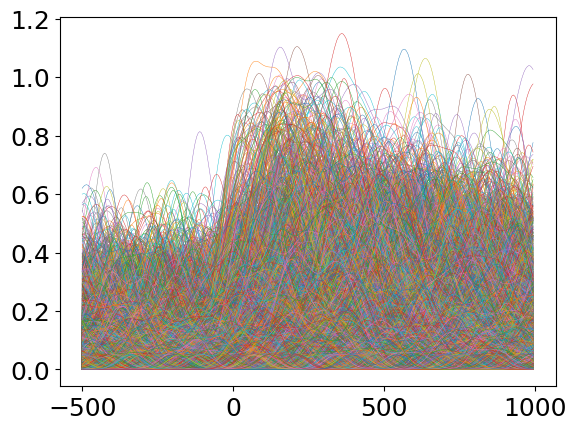

In [16]:
active_trials_spikes = []
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial.spikes_smth_40,label = 'Active',linewidth = .3)
    
# passive_trials_spikes = []
# for _, trial in passive_df.groupby('trial_id'):
#     plt.plot(x_axis,trial.spikes,"-o",color = 'k',label = 'Active')
# fig, ax = plt.subplots(figsize=(8,6))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# plt.legend()
# # plt.title('Peristimulus aligned to move_onset')
# plt.ylabel('Average Firing Rate (sp/s)')
# plt.xlabel('Time after movement onset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    

# # plt.xlim([-100,100])
# plt.tight_layout()
# plt.show()
# # plt.savefig(figDir + monkey + '_psth.pdf',dpi = 'figure')

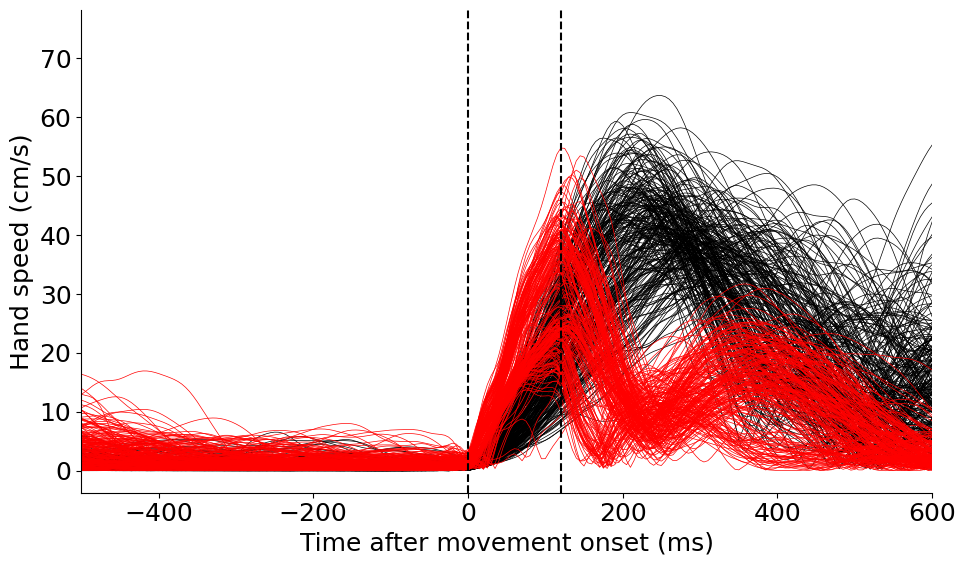

In [8]:
plot_range = (-500, 1000)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_5ms.bin_width)
active_df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask)
passive_df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~passive_mask)

fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial.speed, color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial.speed, color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand speed (cm/s)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Speed aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,600])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_speed_whole.pdf',dpi = 'figure')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial.acceleration, color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial.acceleration, color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Change of speed (cm/s^2)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Change of speed aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,600])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_acc_whole.pdf',dpi = 'figure')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial['hand_vel']['x'], color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial['hand_vel']['x'], color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand velocity (cm/s)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Velocity_x aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,500])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_vel_x_whole.pdf', dpi = 'figure')
# plt.close()

fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial['hand_vel']['y'], color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial['hand_vel']['y'], color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand velocity (cm/s)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Velocity_y aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,500])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_vel_y_whole.pdf', dpi = 'figure')
# plt.close()

In [ ]:
# plt.figure(figsize=(10,6))
# for _, trial in active_df.groupby('trial_id'):
#     plt.plot(x_axis,trial['manip_force']['x'], color='k', linewidth=0.5)
# for _, trial in passive_df.groupby('trial_id'):
#     plt.plot(x_axis, trial['manip_force']['x'], color='red', linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Force(N)')
# plt.axvline(0, color = 'k',linestyle = '--')
# # plt.title('Force_x aligned to move_onset')
# plt.axvline(120, color = 'k',linestyle = '--')
# plt.xlim([-500,600])
# plt.tight_layout()
# plt.savefig(figDir + monkey + '_force_x_whole.pdf', dpi = 'figure')
# plt.close()

# plt.figure(figsize=(10,6))
# for _, trial in active_df.groupby('trial_id'):
#     plt.plot(x_axis,trial['manip_force']['y'], color='k', linewidth=0.5)
# for _, trial in passive_df.groupby('trial_id'):
#     plt.plot(x_axis, trial['manip_force']['y'], color='red', linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Force(N)')
# plt.axvline(0, color = 'k',linestyle = '--')
# # plt.title('Force_y aligned to move_onset')
# plt.axvline(120, color = 'k',linestyle = '--')
# plt.xlim([-500,600])
# plt.tight_layout()
# plt.savefig(figDir + monkey + '_force_y_whole.pdf', dpi = 'figure')
# plt.close()

# plt.figure(figsize=(10,6))
# for _, trial in active_df.groupby('trial_id'):
#     plt.plot(x_axis,trial['manip_force']['z'], color='k', linewidth=0.5)
# for _, trial in passive_df.groupby('trial_id'):
#     plt.plot(x_axis, trial['manip_force']['z'], color='red', linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Force(N)')
# plt.axvline(0, color = 'k',linestyle = '--')
# # plt.title('Force_z aligned to move_onset')
# plt.axvline(120, color = 'k',linestyle = '--')
# plt.xlim([-500,600])
# plt.tight_layout()
# plt.savefig(figDir + monkey + '_force_z_whole.pdf', dpi = 'figure')
# plt.close()


In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial['hand_acc']['x'], color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial['hand_acc']['x'], color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Acceleration_x aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,600])
plt.tight_layout()
plt.savefig(figDir + monkey + '_acc_x_whole.pdf', dpi = 'figure')
plt.close()

fig, ax = plt.subplots(figsize=(10,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for _, trial in active_df.groupby('trial_id'):
    plt.plot(x_axis,trial['hand_acc']['y'], color='k', linewidth=0.5)
for _, trial in passive_df.groupby('trial_id'):
    plt.plot(x_axis, trial['hand_acc']['y'], color='red', linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.axvline(0, color = 'k',linestyle = '--')
# plt.title('Acceleration_y aligned to move_onset')
plt.axvline(120, color = 'k',linestyle = '--')
plt.xlim([-500,600])
plt.tight_layout()
plt.savefig(figDir + monkey + '_acc_y_whole.pdf', dpi = 'figure')
plt.close()

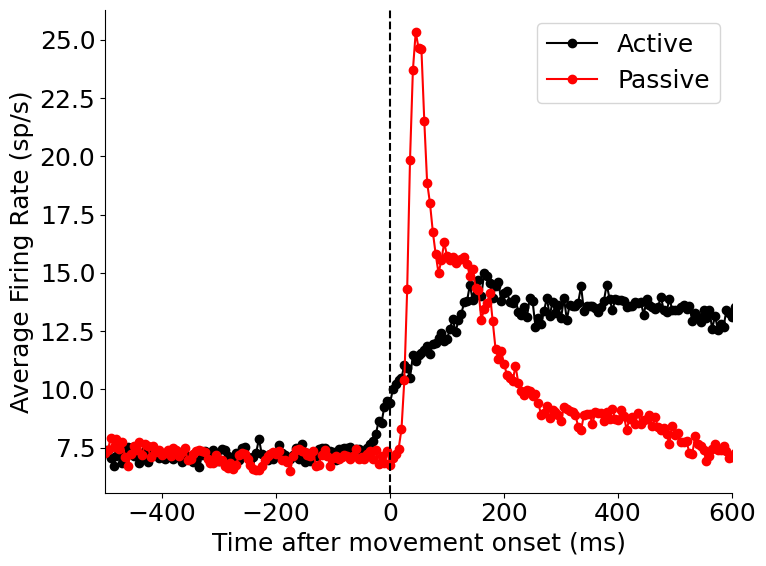

In [10]:
active_trials_spikes = []
for _, trial in active_df.groupby('trial_id'):
    active_trials_spikes.append(np.sum(trial.spikes,axis=1))
passive_trials_spikes = []
for _, trial in passive_df.groupby('trial_id'):
    passive_trials_spikes.append(np.sum(trial.spikes,axis=1))
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_5ms.bin_width*1000/len(active_trials_spikes)/n_neurons,"-o",color = 'k',label = 'Active')
plt.plot(x_axis,np.sum(passive_trials_spikes,axis = 0)/dataset_5ms.bin_width*1000/len(passive_trials_spikes)/n_neurons,"-o",color = 'red',label = 'Passive')
plt.legend()
# plt.title('Peristimulus aligned to move_onset')
plt.ylabel('Average Firing Rate (sp/s)')
plt.xlabel('Time after movement onset (ms)')
plt.axvline(0, color = 'k',linestyle = '--')   
plt.xlim([-500,600])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_psth_whole.pdf', dpi = 'figure')

# Reaching Directions

In [144]:
def procX_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:]
    X_test = X[test_set,:]
    y_train = y[training_set,:]
    y_test = y[test_set,:]    
    
    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)   

    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
 
    return X_train,X_test,y_train,y_test

In [111]:
pred_range = (-300, 320)
mask = active_mask
n_trials = active_n_trials
cond_dict = active_cond_dict
dim = n_dims
active_df = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~mask)
dirs = [dataset_20ms.trial_info[dataset_20ms.trial_info.trial_id == i]['cond_dir'] for i in active_df.trial_id]
cos_x = [round(math.cos(math.radians(i)),3) for i in dirs]
sin_y = [round(math.sin(math.radians(i)),3) for i in dirs]
cos_sin = np.array([cos_x, sin_y]).T
act_trial_PCA = active_df.PCA.to_numpy().reshape((n_trials, -1, dim))
print(act_trial_PCA.shape)
act_trial_ang = cos_sin.reshape((n_trials, -1, 2))
print(act_trial_ang.shape)

(245, 31, 20)
(245, 31, 2)


In [112]:
n_bins = act_trial_PCA.shape[1]
act_coefs_arr = nans([n_bins, 2, dim])
act_offset_arr = nans([n_bins, 2])

act_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = act_trial_PCA[:,i,:]
    Y = act_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_proc, Y)
    act_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    act_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    act_r2_arr[i] = R2

In [113]:
pred_range = (-300, 320)
mask = passive_mask
n_trials = passive_n_trials
cond_dict = passive_cond_dict
passive_df = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~mask)
dirs = [dataset_20ms.trial_info[dataset_20ms.trial_info.trial_id == i]['cond_dir'] for i in passive_df.trial_id]
cos_x = [round(math.cos(math.radians(i)),3) for i in dirs]
sin_y = [round(math.sin(math.radians(i)),3) for i in dirs]
cos_sin = np.array([cos_x, sin_y]).T
pas_trial_PCA = passive_df.PCA.to_numpy().reshape((n_trials, -1, dim))
print(pas_trial_PCA.shape)
pas_trial_ang = cos_sin.reshape((n_trials, -1, 2))
print(pas_trial_ang.shape)

(218, 31, 20)
(218, 31, 2)


In [114]:
pas_coefs_arr = nans([n_bins, 2, dim])
pas_offset_arr = nans([n_bins, 2])
pas_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_proc, Y)
    pas_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    pas_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    pas_r2_arr[i] = R2

In [180]:
act_aff_coef = act_coefs_arr[np.argwhere(np.arange(-300, 320,20)==80)[0,0]]
act_aff_offset = act_offset_arr[np.argwhere(np.arange(-300, 320,20)==80)[0,0]]
act_eff_coef = act_coefs_arr[np.argwhere(np.arange(-300, 320,20)==-60)[0,0]]
act_eff_offset = act_offset_arr[np.argwhere(np.arange(-300, 320,20)==-60)[0,0]]
pas_aff_coef = pas_coefs_arr[np.argwhere(np.arange(-300, 320,20)==40)[0,0]]
pas_aff_offset = pas_offset_arr[np.argwhere(np.arange(-300, 320,20)==40)[0,0]]

In [185]:
act_pas_r2_arr = nans([n_bins])
for i in range(n_bins):
    X_train = act_trial_PCA[:,i,:]
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    Y_hat = X_proc@act_aff_coef.T + act_aff_offset
    sses =get_sses_pred(Y,Y_hat)
    sses_mean=get_sses_mean(Y)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    act_pas_r2_arr[i] = R2

In [186]:
pas_act_r2_arr = nans([n_bins])
for i in range(n_bins):
    X_train = pas_trial_PCA[:,i,:]
    X = act_trial_PCA[:,i,:]
    Y = act_trial_ang[:,i,:]
    X_proc = (X - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    Y_hat = X_proc@pas_aff_coef.T + pas_aff_offset
    sses =get_sses_pred(Y,Y_hat)
    sses_mean=get_sses_mean(Y)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    pas_act_r2_arr[i] = R2

In [187]:
act_pas_eff_r2_arr = nans([n_bins])
for i in range(n_bins):
    X_train = act_trial_PCA[:,i,:]
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    Y_hat = X_proc@act_eff_coef.T + act_eff_offset
    sses =get_sses_pred(Y,Y_hat)
    sses_mean=get_sses_mean(Y)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    act_pas_eff_r2_arr[i] = R2

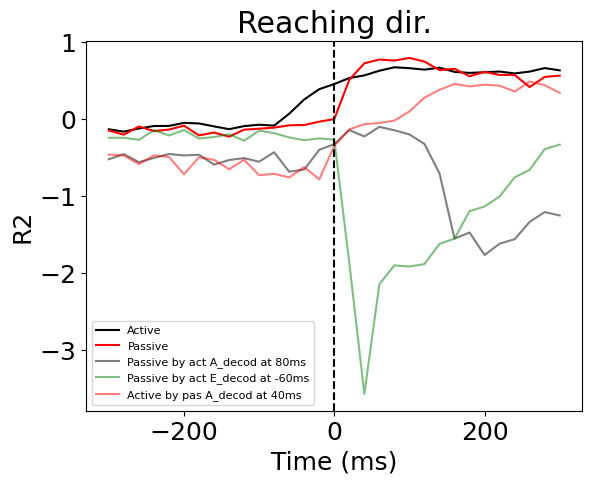

In [196]:
lag_axis = np.arange(-300,301,20)
plt.plot(lag_axis,act_r2_arr, color = 'k', label = 'Active')
plt.plot(lag_axis,pas_r2_arr, color = 'red', label = 'Passive')
plt.plot(lag_axis,act_pas_r2_arr, color = 'k', alpha =.5, label = 'Passive by act A_decod at 80ms')
plt.plot(lag_axis,act_pas_eff_r2_arr, color = 'green', alpha =.5, label = 'Passive by act E_decod at -60ms')
plt.plot(lag_axis,pas_act_r2_arr, color = 'red', alpha = .5, label = 'Active by pas A_decod at 40ms')
plt.xlabel('Time (ms)'); plt.ylabel('R2'); plt.title('Reaching dir.')
plt.legend(fontsize=8)
plt.axvline(0, color = 'k',linestyle = '--')

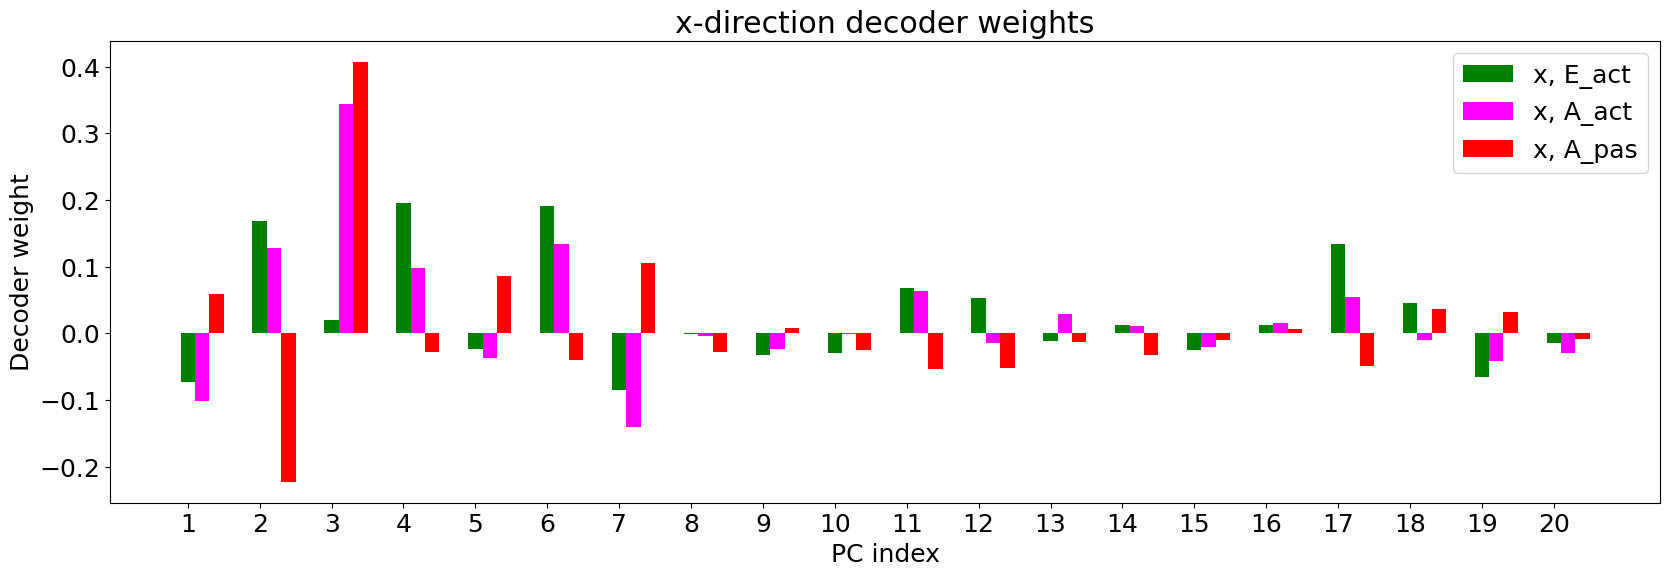

In [194]:
plt.figure(figsize = (20,6))
plt.bar(np.arange(1,n_dims+1,1),act_eff_coef[0],.2, color = 'green', label = 'x, E_act')
plt.bar(np.arange(1,n_dims+1,1)+0.2,act_aff_coef[0],.2, color = 'magenta', label = 'x, A_act')
plt.bar(np.arange(1,n_dims+1,1)+0.4,pas_aff_coef[0],.2, color = 'red', label = 'x, A_pas')


plt.title('x-direction decoder weights')
plt.ylabel('Decoder weight')
plt.xlabel('PC index')
plt.xticks(np.arange(1,n_dims+1,1))
plt.legend()
plt.show()


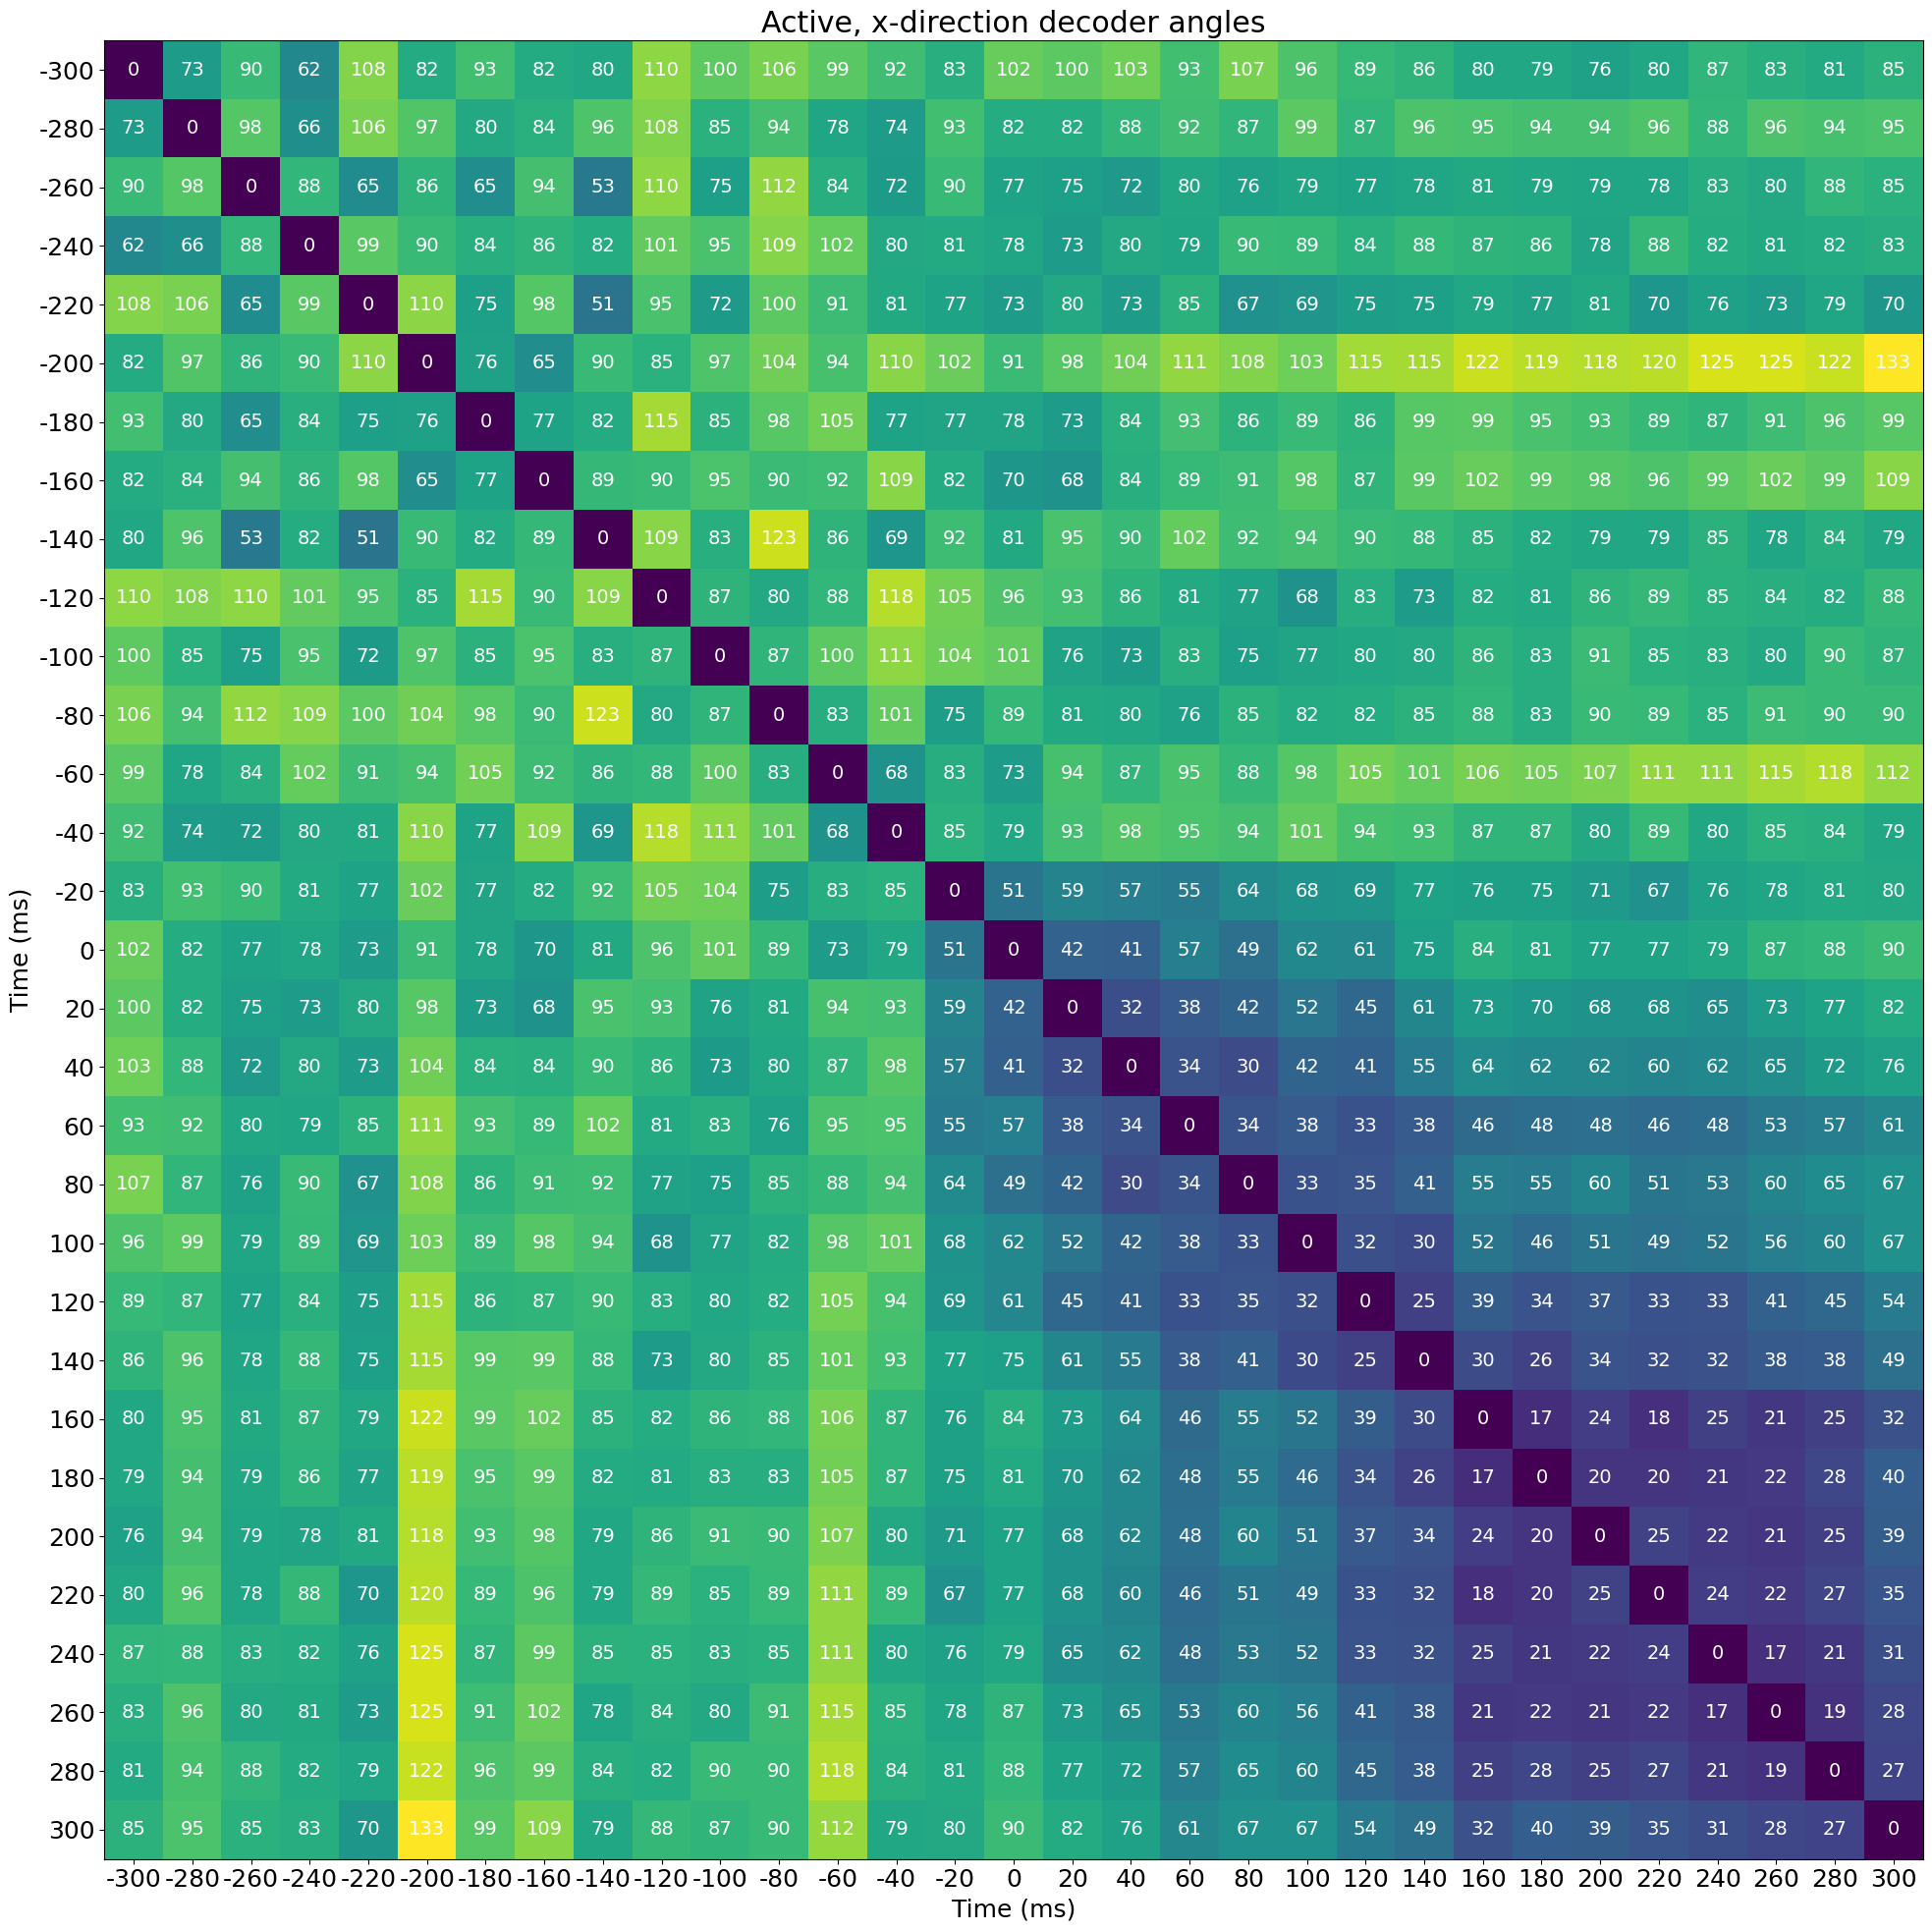

In [32]:
angDist_array = nans([len(act_coefs_arr),len(act_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(act_coefs_arr[i,1,:],act_coefs_arr[j,1,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Active, x-direction decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

# Single Lag

## hi/lo speed inihibition

In [ ]:
## Comarping hi-speed and lo-speed inhibition
plot_range = (0, 120)
active_hi_mask = np.copy(active_mask)
active_lo_mask = np.copy(active_mask)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_5ms.bin_width)
i = 0
for direction in [0,45,90,135,180,225,270,315]:
    direction_mask = (dataset_5ms.trial_info['cond_dir'] == direction) & (dataset_5ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_5ms.trial_info['split'] != 'none')
    df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~direction_mask)
    n_trials = dataset_5ms.trial_info.loc[direction_mask].shape[0]
    speed_array = df.speed.to_numpy().reshape(n_trials, -1)
    trial_mean_speed = np.mean(speed_array,axis=1)
    active_hi_mask[active_cond_dir_idx[i][np.argwhere(trial_mean_speed < np.quantile(trial_mean_speed, 0.7)).flatten()]]= False
    active_lo_mask[active_cond_dir_idx[i][np.argwhere(trial_mean_speed > np.quantile(trial_mean_speed, 0.3)).flatten()]]= False
    i+=1
# plot_range = (0, 500)
# active_hi_mask = np.copy(active_mask)
# active_lo_mask = np.copy(active_mask)
# x_axis = np.arange(plot_range[0], plot_range[1], dataset_5ms.bin_width)

# df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask)
# n_trials = dataset_5ms.trial_info.loc[active_mask].shape[0]
# speed_array = df.speed.to_numpy().reshape(n_trials, -1)
# trial_mean_speed = np.mean(speed_array,axis=1)
# active_hi_mask[np.sort(np.concatenate(active_cond_dir_idx))[np.argwhere(trial_mean_speed < np.quantile(trial_mean_speed, 0.7)).flatten()]]= False
# active_lo_mask[np.sort(np.concatenate(active_cond_dir_idx))[np.argwhere(trial_mean_speed > np.quantile(trial_mean_speed, 0.3)).flatten()]]= False


# hi_trials_idx = np.sort(np.concatenate(active_cond_dir_idx))[np.argwhere(trial_mean_speed > np.quantile(trial_mean_speed, 0.7)).flatten()]
# hi_cond_dict = nans([dataset_5ms.trial_info.loc[active_hi_mask].shape[0]])
# i = 0
# for idx in hi_trials_idx:
#     for cond in range(0,len(active_cond_dir_idx)):
#         if idx in active_cond_dir_idx[cond]:
#             hi_cond_dict[i] = cond
#     i+=1

# lo_trials_idx = np.sort(np.concatenate(active_cond_dir_idx))[np.argwhere(trial_mean_speed < np.quantile(trial_mean_speed, 0.3)).flatten()]
# lo_cond_dict = nans([dataset_5ms.trial_info.loc[active_lo_mask].shape[0]])
# i = 0
# for idx in lo_trials_idx:
#     for cond in range(0,len(active_cond_dir_idx)):
#         if idx in active_cond_dir_idx[cond]:
#             lo_cond_dict[i] = cond
#     i+=1
# plt.hist(hi_cond_dict, bins = 8, color = 'green',alpha = 0.5)
# plt.hist(lo_cond_dict, bins = 8, color = 'blue',alpha = 0.5)
plot_range = (0, 500)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_5ms.bin_width)
df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_hi_mask)
n_trials = dataset_5ms.trial_info.loc[active_hi_mask].shape[0]
speed_array = df.speed.to_numpy().reshape(n_trials, -1)
for speed in speed_array:
    plt.plot(x_axis,speed,color = 'green',alpha = 0.7,linewidth = 0.5)
df = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_lo_mask)
n_trials = dataset_5ms.trial_info.loc[active_lo_mask].shape[0]
speed_array = df.speed.to_numpy().reshape(n_trials, -1)
for speed in speed_array:
    plt.plot(x_axis,speed,color = 'blue',alpha = 0.7,linewidth = 0.5)    

In [ ]:
x_field = 'PCA_40'
y_field ='hand_acc'
lag_axis = np.arange(-300,300,20)
dim = n_dims
pred_range = (-100, 500)

trial_mask = active_hi_mask
r2_array_hi = [mp_fit_lag_r2(dataset_5ms, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field) for lag in lag_axis]
time_max_hi = lag_axis[np.argmax(r2_array_hi)]

trial_mask = active_lo_mask
r2_array_lo = [mp_fit_lag_r2(dataset_5ms, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field) for lag in lag_axis]
time_max_lo = lag_axis[np.argmax(r2_array_lo)]

plt.plot(lag_axis,r2_array_hi, color = 'green')
plt.plot(lag_axis,r2_array_lo,color = 'blue')
plt.ylabel('R2')
plt.xlabel('time lag')
print(time_max_hi)
print(time_max_lo)
print(lag_axis[np.argwhere(r2_array_hi == np.max(r2_array_hi[np.argwhere(lag_axis==0)[0,0]:]))[0,0]])
print(lag_axis[np.argwhere(r2_array_lo == np.max(r2_array_lo[np.argwhere(lag_axis==0)[0,0]:]))[0,0]])

In [ ]:
_, aff_weights, _ = fit_and_predict(dataset_5ms, active_hi_mask, 'move_onset_time', (-100, 500), 40, x_field, y_field)
pred_range = (-100,500)
x_axis = np.arange(pred_range[0], pred_range[1], dataset_5ms.bin_width)
_, _, act_lo_aff_vel_df = pred_with_new_weights(dataset_5ms, active_lo_mask, 'move_onset_time',pred_range, 40,x_field,y_field, aff_weights)
_, _, pas_lo_aff_vel_df = pred_with_new_weights(dataset_5ms, active_lo_mask, 'move_onset_time',pred_range, 40,x_field,y_field, aff_weights)

_, _, act_hi_aff_vel_df = pred_with_new_weights(dataset_5ms, active_hi_mask, 'move_onset_time',pred_range, 40,x_field,y_field, aff_weights)
_, _, pas_hi_aff_vel_df = pred_with_new_weights(dataset_5ms, active_hi_mask, 'move_onset_time',pred_range, 40,x_field,y_field, aff_weights)


plot_dir = [0.0, 180.0] # limit plot directions to reduce cluttering
colors = ['gray','gray']
plot_dim = 'x'
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(18, 6))
i = 0
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id

    for _, trial in act_lo_aff_vel_df[np.isin(act_lo_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[1][i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.5, linewidth=0.5)
        axs[1][i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        axs[1][i].spines[['right', 'top']].set_visible(False) 
    for _, trial in act_hi_aff_vel_df[np.isin(act_hi_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.5, linewidth=0.5)  
        axs[0][i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        axs[0][i].spines[['right', 'top']].set_visible(False)
    i+=2
plot_dir = [90.0, 270.0] # limit plot directions to reduce cluttering
colors = ['gray', 'gray']
plot_dim = 'y'
i = 1
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id

    for _, trial in act_lo_aff_vel_df[np.isin(act_lo_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[1][i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.5, linewidth=0.5)
        axs[1][i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        axs[1][i].spines[['right', 'top']].set_visible(False) 
    for _, trial in act_hi_aff_vel_df[np.isin(act_hi_aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.5, linewidth=0.5)
        axs[0][i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        axs[0][i].spines[['right', 'top']].set_visible(False)
    i+=2

fig.supxlabel('Time after movement onset (ms)')
axs[0][0].set_ylabel('Hand acceleration \n (cm/s^2)',fontsize=14)
axs[1][0].set_ylabel('Hand acceleration \n (cm/s^2)',fontsize=14)

axs[0][0].set_title('0 deg')
axs[0][1].set_title('90 deg')
axs[0][2].set_title('180 deg')
axs[0][3].set_title('270 deg')

## with Neurons

### Neuron weights plot

In [ ]:
#Neuron weights plot
x_field = 'spikes_smth_40'
y_field ='hand_acc'
_, eff_weights, _ = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (-100, 500), -60, x_field, y_field,active_cond_dict)
_, aff_weights,_ = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (-100,500), 80,x_field,y_field,active_cond_dict)
# np.savez(monkey+'_act_acc_decoder_weights',eff_weights = eff_weights, aff_weights = aff_weights) 

eff_weights_X = np.mean(abs(eff_weights), axis=0) #Mean absolute weights between x- and y-decoder
print(eff_weights_X.shape)
aff_weights_X = np.mean(abs(aff_weights), axis=0)
print(aff_weights_X.shape)

# plt.figure(figsize = (15,6))
# plt.bar(np.arange(n_neurons)-0.2,abs(eff_weights_X),.4,label = 'Efferent')
# plt.bar(np.arange(n_neurons)+0.2,abs(aff_weights_X),.4,label = 'Afferent')
# # plt.title('Neuron Weights')
# plt.ylabel('Decoder weight')
# plt.xlabel('Neuron index')
# plt.legend()
# plt.tight_layout()
# plt.savefig(figDir + monkey + '_weights.pdf', dpi = 'figure')

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
    
plt.hist(aff_weights_X)
plt.show()
plt.hist(eff_weights_X)
plt.show()

Ki_x = []
for i in range(n_neurons):
    Wa = aff_weights_X[i]
    We = eff_weights_X[i]
    if abs(Wa) > 0.05 or abs(We) > 0.05:
        Ki_x.append((abs(Wa) - abs(We)) / (abs(Wa)+abs(We)))
print(len(Ki_x))
fig, ax = plt.subplots(figsize=(5, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# fig.suptitle('Relative contribution to acc decoder between Afference and Efference')
import seaborn as sns
parts = ax.violinplot(Ki_x,showmeans = False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)

quartile1, medians, quartile3 = np.percentile(Ki_x, [25, 50, 75])
whiskers = adjacent_values(sorted(Ki_x), quartile1, quartile3)
whiskers_min, whiskers_max = whiskers[0], whiskers[1]
ax.scatter(1, medians, marker='o', color='white', s=20, zorder=3)
ax.vlines(1, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(1, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax.set_ylabel('Relative contribution')
ax.set_xticks([])
# ax.set_xlabel('All neurons')
ax.set_ylim([-1,1])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_contrib_violin.pdf', dpi = 'figure')

fig, ax = plt.subplots(figsize=(8, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist(sorted(Ki_x),10,rwidth=0.8,color = 'grey')
plt.xlabel('Relative contribution')
plt.ylabel('Neuron count')
plt.xlim([-1.1,1.1])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_contrib_bar.pdf', dpi = 'figure')

### Lag analysis

In [ ]:
lag_axis = np.arange(-300,300,20)
x_field = 'spikes_smth_40'
y_field ='hand_acc'
trial_mask = active_mask
cond_dict = active_cond_dict

# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/neurons/'

dim = n_neurons

In [ ]:
pred_range = (-100,500)
label = '_whole_acc_'

x_axis = np.arange(pred_range[0], pred_range[1], dataset_5ms.bin_width)
r2_array = [mp_fit_lag_r2(dataset_5ms, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, cond_dict) for lag in lag_axis]
time_max = lag_axis[np.argmax(r2_array)]
_, weights, vel_df = fit_and_predict(dataset_5ms, trial_mask, 'move_onset_time', pred_range, time_max, x_field, y_field, cond_dict = cond_dict)

In [ ]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.65,0.65])
plt.tight_layout()
plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.65,0.65])
plt.tight_layout()
plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.ylim([0.15,0.65])
plt.tight_layout()
plt.savefig(figDir + monkey + label + str(0) +'.pdf', dpi = 'figure')
plt.show()


In [ ]:
#subtract predictions with primary decoding dimensions (at time with max R2)
sub_r2_array = [mp_sub_lag_r2(dataset_5ms, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, weights, cond_dict) for lag in lag_axis]
time_max = lag_axis[np.argmax(sub_r2_array)]
_, new_weights, vel_df = sub_and_predict(dataset_5ms, trial_mask, 'move_onset_time', pred_range, time_max, x_field, y_field,weights, cond_dict = cond_dict)

In [ ]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.65,0.65])
plt.tight_layout()
plt.savefig(figDir + monkey + label + str(1) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, sub_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.ylim([0.15,0.65])
plt.tight_layout()
plt.savefig(figDir + monkey + label + str(1) +'.pdf', dpi = 'figure')
plt.show()

## with PCA

### a^ = W(a, e)

-20


Text(0, 0.5, 'R2')

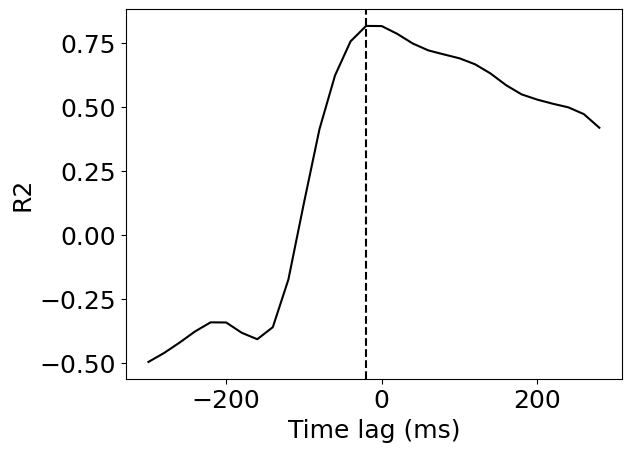

In [23]:
dataset = dataset_5ms
x_field = 'spikes_smth_40'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)
dim = n_neurons

# Get a from passive trials
pred_range = (-100, 120)
pas_r2_array = nans([len(lag_axis)])
pas_coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_,_ = fit_and_predict(dataset, passive_mask, 'move_onset_time',pred_range, lag, x_field, y_field,passive_cond_dict)
    pas_r2_array[i] = r2
    pas_coef_array[i,:,:] = coef
pas_time_max = lag_axis[np.argmax(pas_r2_array)]
print(pas_time_max)
pas_aff_coef = pas_coef_array[np.argmax(pas_r2_array),:,:]
plt.plot(lag_axis, pas_r2_array,color = 'k')
plt.axvline(pas_time_max, color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')

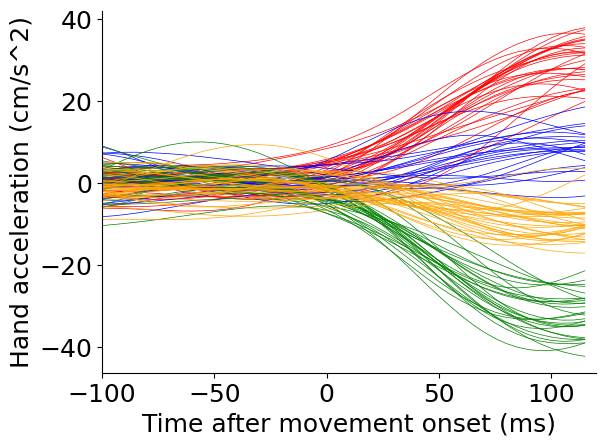

In [24]:
_, _, _,vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time',(-100,120), pas_time_max, x_field, y_field, passive_cond_dict)
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
x_axis = np.arange(-100,120,5)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,120])
plt.tight_layout()
plt.show()

80
-60
80
-80
80
-80
80
-80
80
-80
80
-80


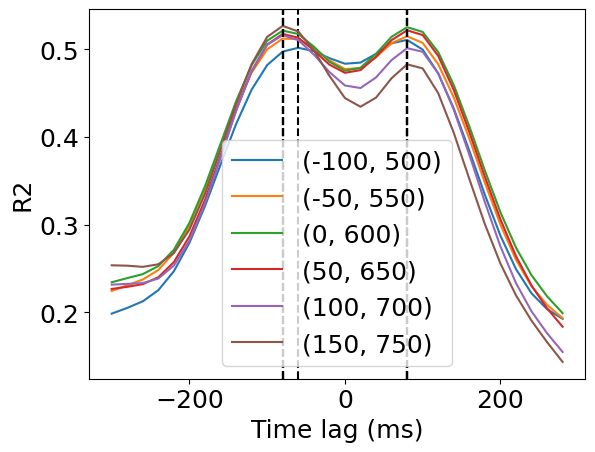

In [83]:
# Get a* and e from active trials
dataset = dataset_5ms
x_field = 'PCA_40'
y_field ='hand_acc'
lag_axis = np.arange(-300,300,20)
dim = n_dims

pred_range_list = [(-100, 500), (-50, 550), (0, 600), (50, 650), (100, 700),(150, 750)]
for pred_range in pred_range_list:
    act_r2_array = nans([len(lag_axis)])
    act_coef_array = nans([len(lag_axis),2,dim])
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, coef,_,_ = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field, active_cond_dict)
        act_r2_array[i] = r2
        act_coef_array[i,:,:] = coef

    idx_max_pos = np.argwhere(act_r2_array == np.max(act_r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
    idx_max_neg = np.argwhere(act_r2_array == np.max(act_r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
    print(lag_axis[idx_max_pos])
    print(lag_axis[idx_max_neg])

    # act_eff_coef = act_coef_array[idx_max_neg,:,:]
    # act_aff_coef = act_coef_array[idx_max_pos,:,:]
    plt.plot(lag_axis, act_r2_array, label = str(pred_range))
    plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
    plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
    plt.xlabel('Time lag (ms)')
    plt.ylabel('R2')
plt.legend()

80
-60


Text(0, 0.5, 'R2')

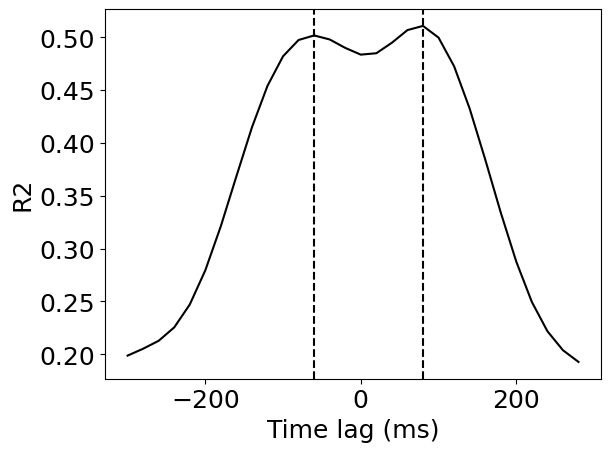

In [35]:
idx_max_pos = np.argwhere(act_r2_array == np.max(act_r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(act_r2_array == np.max(act_r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
print(lag_axis[idx_max_pos])
print(lag_axis[idx_max_neg])

act_eff_coef = act_coef_array[idx_max_neg,:,:]
act_aff_coef = act_coef_array[idx_max_pos,:,:]
plt.plot(lag_axis, act_r2_array,color = 'k')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')

83.06487201033728
91.27175370567333
86.09487805457427
89.04161214628759


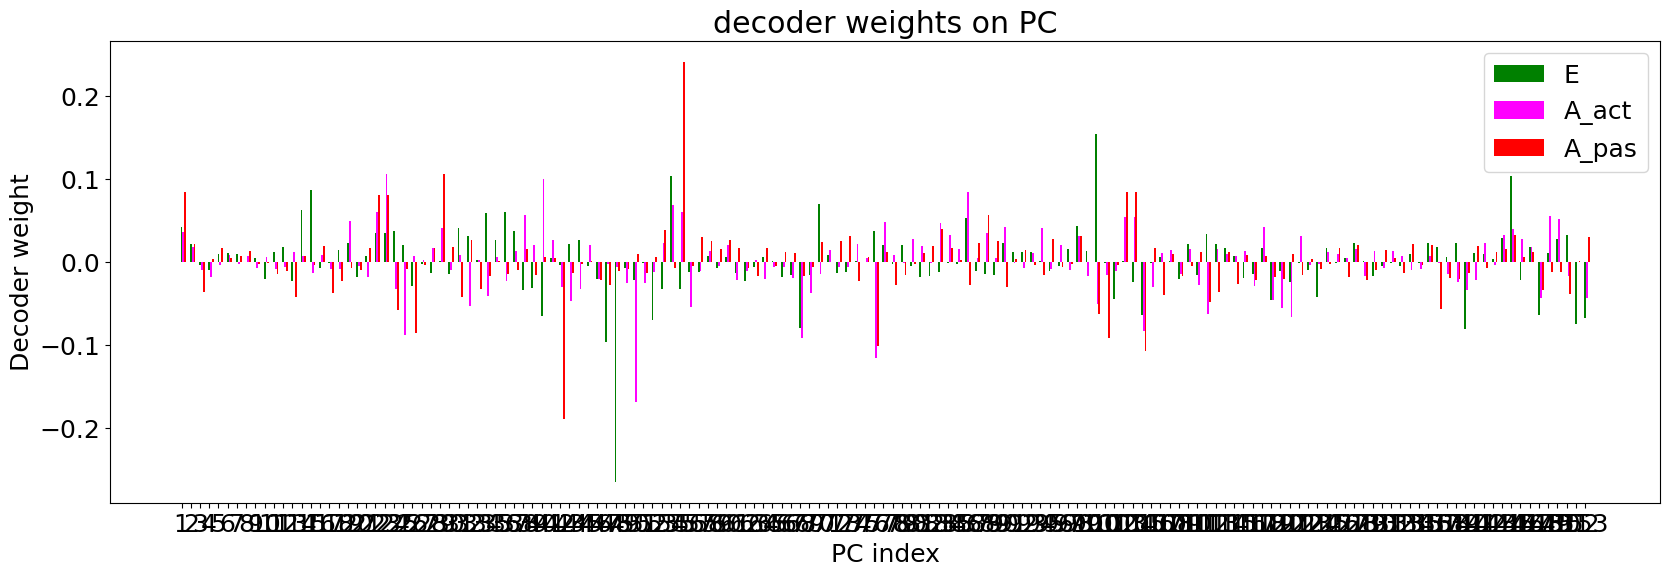

In [30]:
plt.figure(figsize = (20,6))
plt.bar(np.arange(1,dim+1,1),act_eff_coef[0],.2, color = 'green', label = 'E')
plt.bar(np.arange(1,dim+1,1)+0.2,act_aff_coef[0],.2, color = 'magenta', label = 'A_act')
plt.bar(np.arange(1,dim+1,1)+0.4,pas_aff_coef[0],.2, color = 'red', label = 'A_pas')

plt.title('decoder weights on PC')
plt.ylabel('Decoder weight')
plt.xlabel('PC index')
plt.xticks(np.arange(1,dim+1,1))
plt.legend()
print(math.degrees(angle_between(act_eff_coef[0], act_aff_coef[0])))
print(math.degrees(angle_between(act_eff_coef[0], pas_aff_coef[0])))
print(math.degrees(angle_between(act_eff_coef[1], act_aff_coef[1])))
print(math.degrees(angle_between(act_eff_coef[1], pas_aff_coef[1])))
plt.show()


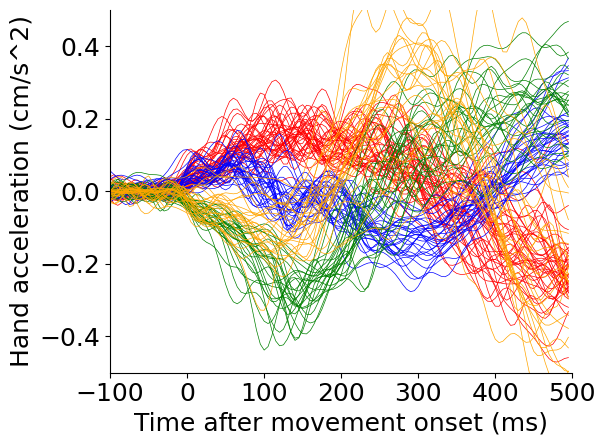

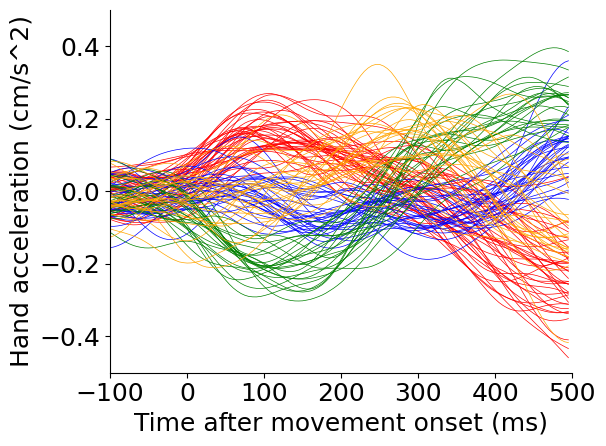

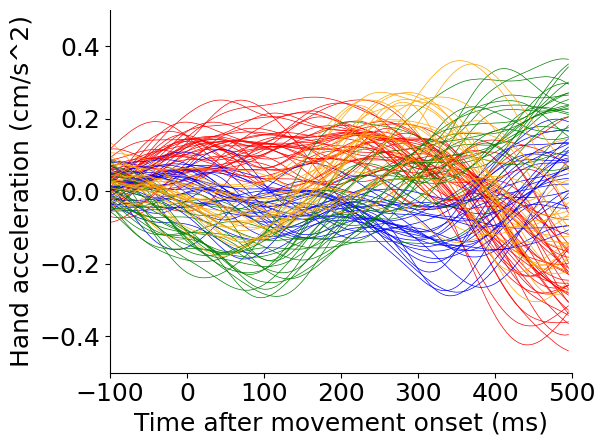

In [71]:
_, _, _,vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',(-100,500), lag_axis[idx_max_neg], x_field, y_field, active_cond_dict)
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
x_axis = np.arange(-100,500,5)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()

_, _,_, vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',(-100,500), lag_axis[idx_max_pos], x_field, y_field, active_cond_dict)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()

In [72]:
n_timepoints = int((500 - -100)/5)

true = vel_df['hand_acc'].to_numpy().reshape((n_trials, n_timepoints, -1))
pred = vel_df['pred_vel'].to_numpy().reshape((n_trials, n_timepoints, -1))

In [ ]:
sses = get_sses_pred(true,pred)
sses_mean = get_sses_mean(true)
eff_r2_time = 1 - np.sum(sses,axis = 1)/np.sum(sses_mean,axis = 1)
plt.plot(x_axis[20:], eff_r2_time[20:])

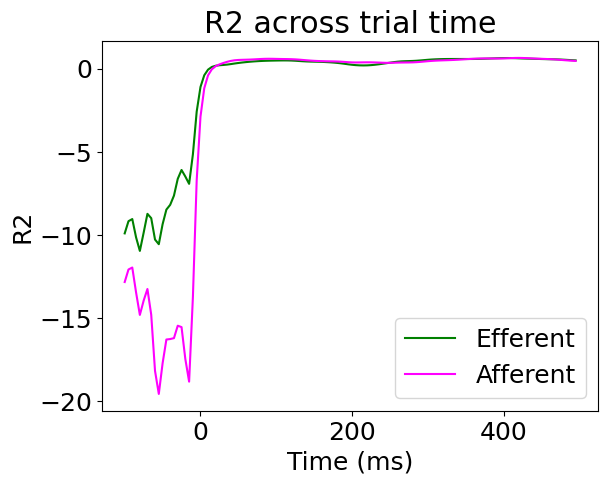

In [81]:
sses = get_sses_pred(true,pred)
sses_mean = get_sses_mean(true)
aff_r2_time = 1 - np.sum(sses,axis = 1)/np.sum(sses_mean,axis = 1)
plt.plot(x_axis, eff_r2_time,color = 'green',label = 'Efferent')
plt.plot(x_axis, aff_r2_time, color = 'magenta', label = 'Afferent')
plt.xlabel('Time (ms)')
plt.ylabel('R2')
plt.title('R2 across trial time')
plt.legend()

Text(0, 0.5, 'Angle (degrees)')

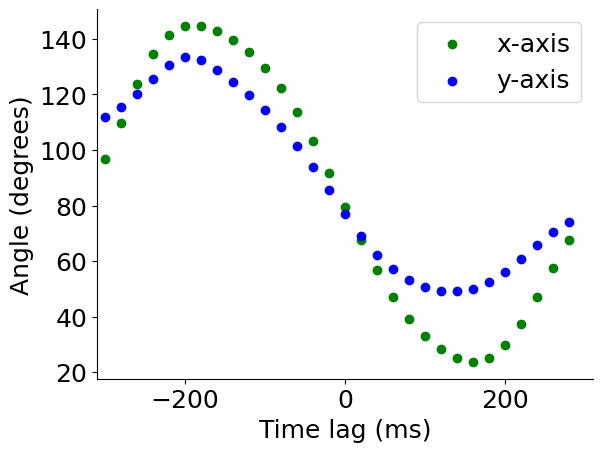

In [13]:
ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
for i in range(0, len(act_coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(pas_aff_coef[0,:],act_coef_array[i,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(pas_aff_coef[1,:],act_coef_array[i,1,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x-axis',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y-axis',color = 'blue')
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')

In [634]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
reg_r2_array = nans([len(lag_axis)])
reg_r2_x = nans([len(lag_axis)])
reg_r2_y = nans([len(lag_axis)])

reg_coef_array = nans([len(lag_axis),2,2])
pred_r2 = nans([len(lag_axis)])
pred_r2_xshat = nans([len(lag_axis)])
pred_r2_yshat = nans([len(lag_axis)])
pred_r2_xs = nans([len(lag_axis)])
pred_r2_ys = nans([len(lag_axis)])
pred_r2_x = nans([len(lag_axis)])
pred_r2_y = nans([len(lag_axis)])
pred_r2_xe = nans([len(lag_axis)])
pred_r2_ye = nans([len(lag_axis)])

for i in range(len(lag_axis)):
    lag = lag_axis[i]
    Y_0 = act_aff_coef[0,:].T
    X_0 = np.append(act_eff_coef[0,None], pas_aff_coef[0,None],axis = 0).T
    lr_0 = LinearRegression(fit_intercept=False).fit(X_0,Y_0)
    Y_hat_0 = lr_0.predict(X_0).T
    reg_coef_array[i,0,:]=lr_0.coef_

    Y_1 = act_aff_coef[1,:].T
    X_1 = np.append(act_eff_coef[1,None], pas_aff_coef[1,None],axis = 0).T
    lr_1 = LinearRegression(fit_intercept=False).fit(X_1,Y_1)
    Y_hat_1 = lr_1.predict(X_1).T
    reg_coef_array[i,1,:]=lr_1.coef_

    reg_r2_x[i] = r2_score(Y_0, Y_hat_0)
    reg_r2_y[i] = r2_score(Y_1, Y_hat_1)
    reg_r2_array[i] = (r2_score(Y_0, Y_hat_0)+r2_score(Y_1, Y_hat_1))/2

    As_hat = np.stack([Y_hat_0,Y_hat_1])
    pred_range = (-100,500)
    r2,_,r2_x,r2_y,_ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range,lag,
                                             x_field,y_field, As_hat, 0, (-100, 500), (pred_range[0]+lag, pred_range[1]+lag), active_mask)
    pred_r2[i] = r2
    pred_r2_xshat[i] = r2_x
    pred_r2_yshat[i] = r2_y

    As = act_aff_coef
    _,_,r2_x,r2_y,_ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range,lag,
                                            x_field,y_field, As, 0,(-100, 500), (pred_range[0]+lag, pred_range[1]+lag), active_mask)
    pred_r2_xs[i] = r2_x
    pred_r2_ys[i] = r2_y

    A = pas_aff_coef
    _,_,r2_x,r2_y,_ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range,lag,
                                            x_field,y_field, A, 0,(-100, 500), (pred_range[0]+lag, pred_range[1]+lag), active_mask)
    pred_r2_x[i] = r2_x
    pred_r2_y[i] = r2_y


    E = act_eff_coef
    _,_,r2_x,r2_y,_ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range,lag,
                                            x_field,y_field, E, 0,(-100, 500), (pred_range[0]+lag, pred_range[1]+lag), active_mask)
    pred_r2_xe[i] = r2_x
    pred_r2_ye[i] = r2_y
    # X = np.append(act_eff_coef, pas_aff_coef,axis = 0).T
    # Y = act_coef_array[i,:,:].T
    # lr = LinearRegression().fit(X,Y)
    # Y_hat = lr.predict(X).T
    # reg_r2_array[i] = lr.score(X,Y)
    # reg_coef_array[i,:,:]=lr.coef_
    # r2,_,_ = pred_with_new_weights(dataset, active_mask, 'move_onset_time',(-100, 500),lag ,x_field,y_field, Y_hat)
    # reg_pred_r2[i] = r2

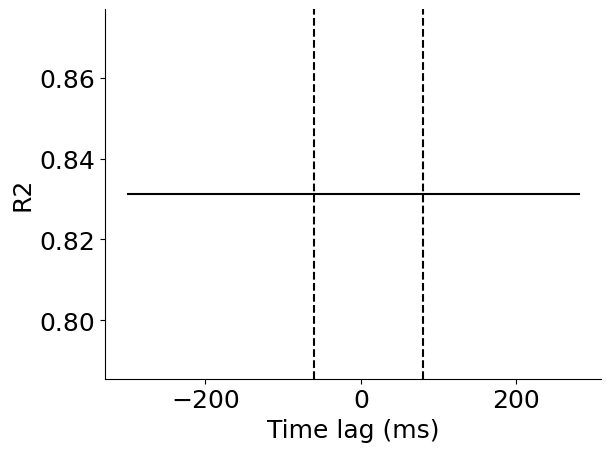

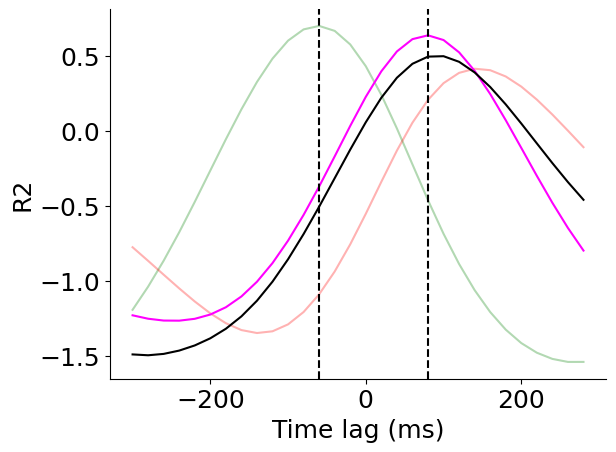

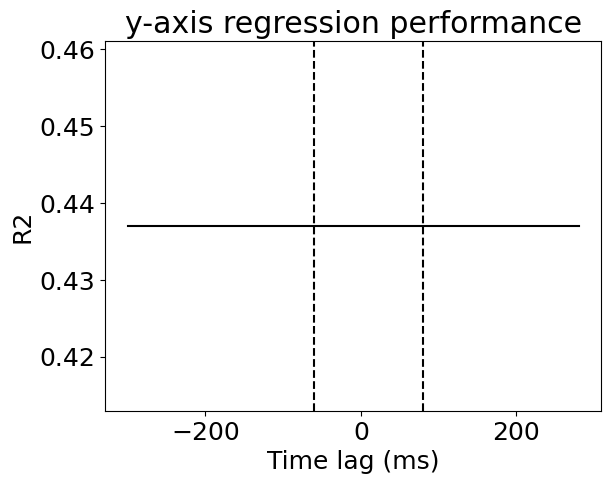

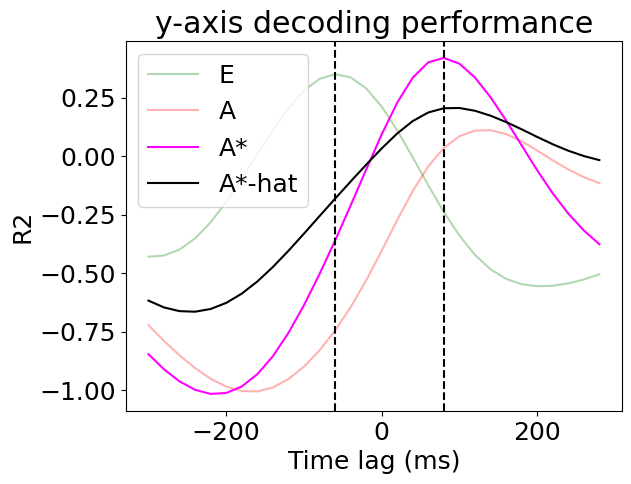

In [636]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis,reg_r2_x, color = 'k')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.title('x-axis regression performance')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis,pred_r2_xe, color = 'green',alpha = 0.3, label = 'E')
plt.plot(lag_axis,pred_r2_x, color = 'red',alpha = 0.3, label = 'A')
plt.plot(lag_axis,pred_r2_xs, color = 'magenta',label = 'A*')
plt.plot(lag_axis,pred_r2_xshat, color = 'k',label = 'A*-hat')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.title('x-axis decoding performance')
# plt.legend()
plt.show()

plt.plot(lag_axis,reg_r2_y, color = 'k')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.title('y-axis regression performance')
plt.show()

plt.plot(lag_axis,pred_r2_ye, color = 'green',alpha = 0.3,label = 'E')
plt.plot(lag_axis,pred_r2_y, color = 'red',alpha = 0.3,label = 'A')
plt.plot(lag_axis,pred_r2_ys, color = 'magenta',label = 'A*')
plt.plot(lag_axis,pred_r2_yshat, color = 'k',label = 'A*-hat')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.title('y-axis decoding performance')
plt.legend()
plt.show()

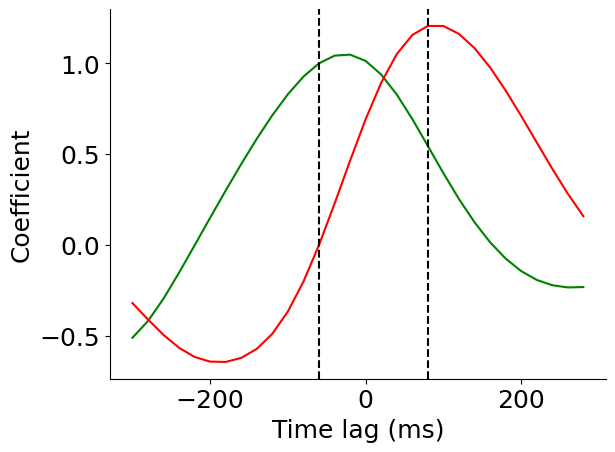

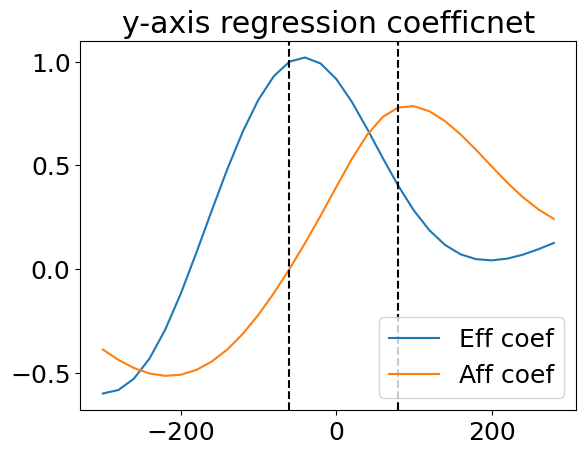

In [32]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, reg_coef_array[:,0,0], color = 'green',label = 'Eff coef')
plt.plot(lag_axis, reg_coef_array[:,0,1], color = 'red',label = 'Aff coef')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
# plt.title('x-axis regression coefficnet')
plt.ylabel('Coefficient')
plt.xlabel('Time lag (ms)')
# plt.legend()
plt.show()

plt.plot(lag_axis, reg_coef_array[:,1,0], label = 'Eff coef')
plt.plot(lag_axis, reg_coef_array[:,1,1], label = 'Aff coef')
plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
plt.title('y-axis regression coefficnet')
plt.legend()

In [ ]:
# from sklearn.linear_model import LinearRegression
# Y = act_aff_coef.T
# X = np.append(act_eff_coef, pas_aff_coef,axis = 0).T
# lr = LinearRegression().fit(X,Y)
# act_aff_hat = lr.predict(X).T
# print(lr.score(X,Y))
# print(lr.coef_)
# print(lr.coef_.shape)

# r2,r,vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',(-100, 500),lag_axis[idx_max_pos] ,x_field,y_field, act_aff_hat)
# print(r2)
# print(r)

In [18]:
from sklearn.linear_model import LinearRegression

lag = 80
lag_idx = np.argwhere(lag_axis==lag)[0,0]
Y_0 = act_coef_array[lag_idx,0,:].T
X_0 = np.append(act_eff_coef[0,None], pas_aff_coef[0,None],axis = 0).T
lr_0 = LinearRegression().fit(X_0,Y_0)
Y_hat_0 = lr_0.predict(X_0).T

Y_1 = act_coef_array[lag_idx,1,:].T
X_1 = np.append(act_eff_coef[1,None], pas_aff_coef[1,None],axis = 0).T
lr_1 = LinearRegression(fit_intercept=False).fit(X_1,Y_1)
Y_hat_1 = lr_1.predict(X_1).T

Y_hat = np.stack([Y_hat_0,Y_hat_1])

r2,_,_,_,vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',(-100, 500),lag ,x_field,y_field, Y_hat)
print(r2)

plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
x_axis = np.arange(-100,500,5)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()

TypeError: pred_with_new_weights() missing 3 required positional arguments: 'train_range', 'train_lag_range', and 'train_mask'

### Lag analysis

In [ ]:
dataset = dataset_5ms
x_field = 'PCA_40'
y_field ='hand_acc'
lag_axis = np.arange(-300,300,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = n_dims

In [ ]:
# Angle between decoders
pred_range = (-100, 500)
r2_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,active_cond_dict)
    r2_array[i] = r2
    coef_array[i,:,:] = coef
time_max = lag_axis[np.argmax(r2_array)]
_, weights, vel_df = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict = cond_dict)

In [ ]:
x_axis = np.arange(-100,500,dataset.bin_width)
label = '_whole_vel_'
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand velocity (cm/s)')
plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand velocity (cm/s)')
plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.ylim([0.15,0.55])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'.pdf', dpi = 'figure')
plt.show()


In [ ]:
idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
print(lag_axis[idx_max_pos])
print(lag_axis[idx_max_neg])

#For velocity, override max identification
# idx_max_pos = np.argwhere(lag_axis==80)[0,0]
# idx_max_neg = np.argwhere(lag_axis==-40)[0,0]

ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_neg,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_neg,1,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x-axis',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y-axis',color = 'blue')
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')
mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
print(mean)
plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
plt.show()


In [ ]:
# #For velocity, override max id
# dataset = dataset_20ms
# x_field = 'spikes'
# y_field ='hand_vel'
# pred_range = (-100,1000)
# x_axis = np.arange(-100,1000,dataset.bin_width)
# cond_dict = active_cond_dict
# trial_mask = active_mask

# lag_choice = -60
# _, weights, vel_df = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, lag_choice, x_field, y_field, cond_dict = cond_dict)

# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand acceleration (cm/s^2)')
# plt.xlim([-100,1000])
# # plt.ylim([-0.65,0.65])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
# plt.show()

# lag = 0
# trial_mask = active_mask
# pred_range = (-100,1000)
# x_axis = np.arange(-100,1000,dataset.bin_width)
# r2,r,vel_df = pred_with_new_weights(dataset, trial_mask, 'move_onset_time',pred_range, lag,x_field,y_field, weights)
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand acceleration (cm/s^2)')
# plt.xlim([-100,1000])
# # plt.ylim([-0.5,0.5])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
# plt.show()

In [ ]:
#subtract predictions with primary decoding dimensions (at time with max R2)
sub_r2_array = [mp_sub_lag_r2(dataset, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, weights, cond_dict) for lag in lag_axis]
time_max = lag_axis[np.argmax(sub_r2_array)]
_, new_weights, vel_df = sub_and_predict(dataset, trial_mask, 'move_onset_time', pred_range, time_max, x_field, y_field,weights, cond_dict = cond_dict)

In [ ]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Hand acceleration (cm/s^2)')
plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(1) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, sub_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(time_max)
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.ylim([0.15,0.55])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(1) +'.pdf', dpi = 'figure')
plt.show()

In [ ]:
# lag_axis = np.arange(-300,300,20)
# r2_0 = []
# r2_1 = []
# for lag in lag_axis:
#     r2,_,_ = pred_with_new_weights(dataset, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, weights)
#     r2_0.append(r2)
#     r2,_,_ = pred_with_new_weights(dataset, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, new_weights)
#     r2_1.append(r2)

In [ ]:
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, r2_0,color = 'y',label = 'Efferent')
# plt.plot(lag_axis, r2_1,color = 'c',label = 'Afferent')
# plt.axvline(0, color = 'k', linestyle='--')
# # plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')
# # plt.ylim([0.15,0.55])
# plt.legend()
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + '_demixed.pdf', dpi = 'figure')
# plt.show()

In [ ]:
# r2_pas_0 = []
# r2_pas_1 = []
# for lag in lag_axis:
#     r2,_,_ = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', (-100,120), lag, x_field, y_field, weights)
#     r2_pas_0.append(r2)
#     r2,_,_ = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', (-100,120), lag, x_field, y_field, new_weights)
#     r2_pas_1.append(r2)

In [ ]:
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, r2_pas_0,color = 'y',label = 'Efferent')
# plt.plot(lag_axis, r2_pas_1,color = 'c',label = 'Afferent')
# plt.axvline(0, color = 'k', linestyle='--')
# # plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')
# plt.ylim([0,0.55])
# plt.legend()
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + '_act-pas.pdf', dpi = 'figure')
# plt.show()

# Multi Lags

In [ ]:
dataset_50ms = NWBDataset(filename, split_heldout=False)
xy_vel = dataset_50ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_50ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])

dataset_50ms.resample(50)
print(dataset_50ms.bin_width)

In [ ]:
n_dims = 20 # for PCA

active_mask = (~dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')
passive_mask = (dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')


trial_mask = active_mask
n_trials = dataset_50ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_50ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
else:
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data[~np.isnan(all_data).any(axis=1)])
    pca = PCA(n_components=n_dims,random_state = 42)
    X = pca.fit(X)
    PCA_data = nans([all_data.shape[0],n_dims])
    idx = 0
    for dp in all_data:
        dp = dp.reshape((1, -1))
        if np.isnan(dp).any():
            dp_pca = nans([1,n_dims])
        else:
            dp_pca = pca.transform(scaler.transform(dp))
        PCA_data[idx,:] = dp_pca
        idx+=1

print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

In [ ]:
active_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-400, 700), ignored_trials=~trial_mask)
for idx, trial in active_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

active_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
active_trials_vel = nans([n_trials,n_timepoints,2])
active_trials_acc = nans([n_trials,n_timepoints,2])
active_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in active_data.groupby('trial_id'):
    active_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    active_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    active_trials_acc[i,:,:]=trial.hand_acc.to_numpy()
    active_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(active_trials_neuron.shape)
print(active_trials_vel.shape)
print(active_trials_acc.shape)
print(active_trials_pca.shape)

passive_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-400, 700), ignored_trials=~trial_mask)
for idx, trial in passive_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

passive_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
passive_trials_vel = nans([n_trials,n_timepoints,2])
passive_trials_acc = nans([n_trials,n_timepoints,2])
passive_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in passive_data.groupby('trial_id'):
    passive_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    passive_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    passive_trials_acc[i,:,:]=trial.hand_acc.to_numpy()
    passive_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(passive_trials_neuron.shape)
print(passive_trials_vel.shape)
print(passive_trials_acc.shape)
print(passive_trials_pca.shape)


### with Neurons

In [ ]:
data_range = [-400,700]
figDir = "/Users/sherryan/area2_population_analysis/figures/neurons/act/"
data_x = active_trials_neuron
data_y = active_trials_acc
y_type = 'acceleration'

ranges = [(-100,500),(-100,120)]
labels = ['whole_acc','long_acc']

dim = n_neurons

In [ ]:
for pred_range, label in zip(ranges, labels):

    idx1 = int((pred_range[0] - data_range[0])/dataset_50ms.bin_width)
    idx2 = int(n_timepoints - (data_range[1]-pred_range[1])/dataset_50ms.bin_width)
    
    if pred_range == (-100,500):
        t_before_range = range(0,201,50)
        t_after_range = range(0,201,50)      
    else:        
        t_before_range = range(0,301,50)
        t_after_range = range(0,501,50)

    multi_R2s = nans([len(t_before_range),len(t_after_range)])
    multi_coefs = []
    j,k=0,0
    for time_before in t_before_range:
        coef_arr = []
        for time_after in t_after_range:
            print('Predicting with',-time_before, 'to', time_after,'ms neural data')

            bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
            bins_current= 1 #Whether to use concurrent time bin of neural data
            bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

            n_total_bins = bins_before + bins_current + bins_after

            X =  nans([n_trials,idx2-idx1,n_total_bins*dim])
            i = 0
            for trial_data in data_x:
                trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
                trial_hist = trial_hist[idx1:idx2,:,:]
                trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
                X[i,:,:] = trial_hist_flat
                i+=1
            y = data_y[:,idx1:idx2,:]

            lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
            X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
            y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
            lr_all.fit(X_reshaped, y_reshaped)
            print(lr_all.best_params_['alpha'])

            skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
            true_concat = nans([(n_trials*(idx2-idx1)),2])
            pred_concat = nans([(n_trials*(idx2-idx1)),2])
            trial_save_idx = 0
            for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
                #split training and testing by trials
                X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
                lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
                lr.fit(X_train, y_train)
                y_test_predicted = lr.predict(X_test)
                n = y_test_predicted.shape[0]
                true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
                pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
                trial_save_idx += n

            sses =get_sses_pred(true_concat,pred_concat)
            sses_mean=get_sses_mean(true_concat)
            multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
            print('R2:',multi_R2s[j,k])
            coef_arr.append(lr_all.best_estimator_.coef_)
            k += 1
        j += 1
        k = 0
        multi_coefs.append(coef_arr)

    fig, ax = plt.subplots()
    im = ax.imshow(multi_R2s)
    ax.set_xlabel('Length of lagging info')
    ax.set_ylabel('Length of leading info')

    ax.set_xticks(np.arange(len(t_after_range)))
    ax.set_yticks(np.arange(len(t_before_range)))
    ax.set_xticklabels(labels=t_after_range)
    ax.set_yticklabels(labels=t_before_range)

    ax.set_title('R2 predicting ' + str(pred_range) + ' ' + y_type +'\nwith different lagging/leading info')
    fig.tight_layout()

    for i in range(len(t_before_range)):
        for j in range(len(t_after_range)):
            text = ax.text(j, i, str(int(multi_R2s[i, j]*1000)/1000),
                           ha="center", va="center", color="w")

    plt.tight_layout()
    plt.savefig(figDir + monkey + '_multi_' + label + '.png', dpi = 'figure')
    plt.close()
    
    if pred_range == (-100,500):
        coef_X = multi_coefs[-1][-1][0] #which entry's weights to use

        t_label = np.arange(-200,201,50)

        n_weights = len(t_before_range) + len(t_after_range) - 1
        coef_X_reshaped = coef_X.reshape(n_weights,n_neurons)
        angDist_array = nans([n_weights,n_weights])
        for i in range(n_weights):
            for j in range(n_weights):
                angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(angDist_array)
        ax.set_xlabel('Bin time (ms)')
        ax.set_ylabel('Bin time (ms)')

        ax.set_xticks(np.arange(len(t_label)))
        ax.set_yticks(np.arange(len(t_label)))
        ax.set_xticklabels(labels=t_label)
        ax.set_yticklabels(labels=t_label)

        ax.set_title("Angle between weight vectors at time points")
        fig.tight_layout()

        for i in range(len(t_label)):
            for j in range(len(t_label)):
                text = ax.text(j, i, str(int(angDist_array[i, j])),
                               ha="center", va="center", color="w")
        plt.tight_layout()
        plt.savefig(figDir + monkey + '_multi_' + label + '_deg.png', dpi = 'figure')
        plt.close()

### with PCA

In [ ]:
data_range = [-400,700]
figDir = "/Users/sherryan/area2_population_analysis/figures/PCA/act/"
data_x = active_trials_pca
data_y = active_trials_acc
y_type = 'acceleration'

ranges = [(-100,500),(-100,120)]
labels = ['whole_acc','long_acc']

dim = n_dims

In [ ]:
for pred_range, label in zip(ranges, labels):

    idx1 = int((pred_range[0] - data_range[0])/dataset_50ms.bin_width)
    idx2 = int(n_timepoints - (data_range[1]-pred_range[1])/dataset_50ms.bin_width)

    if pred_range == (-100,500):
        t_before_range = range(0,201,50)
        t_after_range = range(0,201,50)      
    else:        
        t_before_range = range(0,301,50)
        t_after_range = range(0,501,50)

    multi_R2s = nans([len(t_before_range),len(t_after_range)])
    multi_coefs = []
    j,k=0,0
    for time_before in t_before_range:
        coef_arr = []
        for time_after in t_after_range:
            print('Predicting with',-time_before, 'to', time_after,'ms neural data')

            bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
            bins_current= 1 #Whether to use concurrent time bin of neural data
            bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

            n_total_bins = bins_before + bins_current + bins_after

            X =  nans([n_trials,idx2-idx1,n_total_bins*dim])
            i = 0
            for trial_data in data_x:
                trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
                trial_hist = trial_hist[idx1:idx2,:,:]
                trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
                X[i,:,:] = trial_hist_flat
                i+=1
            y = data_y[:,idx1:idx2,:]

            lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)})
            X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
            y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
            lr_all.fit(X_reshaped, y_reshaped)
            print(lr_all.best_params_['alpha'])

            skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
            true_concat = nans([(n_trials*(idx2-idx1)),2])
            pred_concat = nans([(n_trials*(idx2-idx1)),2])
            trial_save_idx = 0
            for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
                #split training and testing by trials
                X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
                lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
                lr.fit(X_train, y_train)
                y_test_predicted = lr.predict(X_test)
                n = y_test_predicted.shape[0]
                true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
                pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
                trial_save_idx += n

            sses =get_sses_pred(true_concat,pred_concat)
            sses_mean=get_sses_mean(true_concat)
            multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
            print('R2:',multi_R2s[j,k])
            coef_arr.append(lr_all.best_estimator_.coef_)
            k += 1
        j += 1
        k = 0
        multi_coefs.append(coef_arr)

    fig, ax = plt.subplots()
    im = ax.imshow(multi_R2s)
    ax.set_xlabel('Length of lagging info')
    ax.set_ylabel('Length of leading info')

    ax.set_xticks(np.arange(len(t_after_range)))
    ax.set_yticks(np.arange(len(t_before_range)))
    ax.set_xticklabels(labels=t_after_range)
    ax.set_yticklabels(labels=t_before_range)

    ax.set_title('R2 predicting ' + str(pred_range) + ' ' + y_type +'\nwith different lagging/leading info')
    fig.tight_layout()

    for i in range(len(t_before_range)):
        for j in range(len(t_after_range)):
            text = ax.text(j, i, str(int(multi_R2s[i, j]*1000)/1000),
                           ha="center", va="center", color="w")

    plt.tight_layout()
    plt.savefig(figDir + monkey + '_multi_' + label + '.png', dpi = 'figure')
    plt.close()
    
    if pred_range == (-100,500):
        coef_X = multi_coefs[-1][-1][0] #which entry's weights to use

        t_label = np.arange(-200,201,50)

        n_weights = len(t_before_range) + len(t_after_range) - 1
        coef_X_reshaped = coef_X.reshape(n_weights,dim)
        angDist_array = nans([n_weights,n_weights])
        for i in range(n_weights):
            for j in range(n_weights):
                angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(angDist_array)
        ax.set_xlabel('Bin time (ms)')
        ax.set_ylabel('Bin time (ms)')

        ax.set_xticks(np.arange(len(t_label)))
        ax.set_yticks(np.arange(len(t_label)))
        ax.set_xticklabels(labels=t_label)
        ax.set_yticklabels(labels=t_label)

        ax.set_title("Angle between weight vectors at time points")
        fig.tight_layout()

        for i in range(len(t_label)):
            for j in range(len(t_label)):
                text = ax.text(j, i, str(int(angDist_array[i, j])),
                               ha="center", va="center", color="w")
        plt.tight_layout()
        plt.savefig(figDir + monkey + '_multi_' + label + '_deg.png', dpi = 'figure')
        plt.close()